In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## 1. Imports & Setup
Import necessary libraries and set global styles.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb
import lightgbm as lgb

sns.set(style='whitegrid', palette='pastel', font_scale=1.1)


## 2. Load Data
Load the training and test datasets.


In [4]:

train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 3: Data Preprocessing

This step involved cleaning and preparing the data before feature engineering and modeling. The goal was to ensure consistency across train and test datasets and handle any irregularities such as missing values, irrelevant features, and duplicate records.

### 3.1 Dropping the ID Column

The `Id` column was removed from both the training and test datasets as it served only as an identifier and had no predictive value.

### 3.2 Separating the Target and Concatenating the Data

The target variable `SalePrice` was separated from the training dataset. Then, the training and test datasets were concatenated into a single dataframe to allow consistent preprocessing across both sets. This combined dataframe made it easier to apply uniform missing value handling, feature transformations, and encoding.

### 3.3 Dataset Overview

Basic dataset statistics were reviewed using `.info()` and `.describe()`. The shapes of the training, test, and combined datasets were checked to confirm proper merging and data integrity. This helped verify that the concatenated dataframe had the correct number of rows and features.

### 3.4 Duplicate Records

The dataset was checked for duplicate rows. Two duplicate entries were found and removed to avoid data leakage and overfitting.

### 3.5 Handling Missing Values

A detailed analysis of missing values was conducted. The total number and percentage of missing values were calculated for each feature. Based on domain knowledge and inspection, missing values were addressed using the following strategies:

- Categorical features that represent absence of a property (such as `PoolQC`, `Fence`, `Alley`, `FireplaceQu`, and basement-related columns) were filled with the string `'None'`.
- `LotFrontage` values were imputed using the median value within each `Neighborhood`, acknowledging that frontage size often depends on neighborhood characteristics.
- `GarageYrBlt` and other numeric features representing physical structures (such as `GarageArea`, `BsmtUnfSF`, etc.) were filled with zeros where appropriate, especially when their related categorical features were also set to `'None'`.
- For remaining categorical features like `KitchenQual`, `MSZoning`, `SaleType`, `Electrical`, and exterior types, missing values were filled with the mode of each respective feature.
- Numerical features not addressed above were filled with the median value of the column.

### 3.6 Dropping Low-Variance Feature: Utilities

The `Utilities` column was dropped from the dataset after identifying that it had minimal variance (mostly containing the value `AllPub`) and a small number of missing entries. Because it offered no predictive benefit, it was excluded from further processing.

### 3.7 Final Validation

After imputation and cleanup, the dataset was re-checked to ensure there were no remaining missing values. At this point, the combined dataset was fully cleaned and ready for further type conversion and feature engineering.


In [5]:
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)


In [6]:
train_labels = train['SalePrice']
train.drop('SalePrice', axis=1, inplace=True)
full = pd.concat([train, test], axis=0)

In [7]:
full.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [8]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt    

In [9]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Combined shape: {full.shape}")


Train shape: (1460, 79)
Test shape: (1459, 79)
Combined shape: (2919, 79)


In [10]:
duplicates = full.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Number of duplicate rows: 2


In [11]:
# Drop exact duplicates (only 2 found)
full.drop_duplicates(inplace=True)


In [12]:
missing = full.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_df = pd.DataFrame({'Missing Values': missing, 'Percentage': 100 * missing / full.shape[0]})
print(missing_df)

              Missing Values  Percentage
PoolQC                  2907   99.657182
MiscFeature             2812   96.400411
Alley                   2720   93.246486
Fence                   2346   80.425094
MasVnrType              1765   60.507371
FireplaceQu             1418   48.611587
LotFrontage              486   16.660953
GarageQual               159    5.450806
GarageYrBlt              159    5.450806
GarageCond               159    5.450806
GarageFinish             159    5.450806
GarageType               157    5.382242
BsmtExposure              82    2.811107
BsmtCond                  82    2.811107
BsmtQual                  81    2.776826
BsmtFinType2              80    2.742544
BsmtFinType1              79    2.708262
MasVnrArea                23    0.788481
MSZoning                   4    0.137127
BsmtFullBath               2    0.068564
Functional                 2    0.068564
BsmtHalfBath               2    0.068564
Utilities                  2    0.068564
BsmtFinSF1      

In [13]:
none_fill = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence',
    'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'MasVnrType'
]
for col in none_fill:
    full[col] = full[col].fillna('None')


In [14]:
full['LotFrontage'] = full.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


In [15]:
full['GarageYrBlt'] = full['GarageYrBlt'].fillna(0)


In [16]:
full['MasVnrArea'] = full['MasVnrArea'].fillna(0)


In [17]:
full['MSZoning'] = full['MSZoning'].fillna(full['MSZoning'].mode()[0])


In [18]:
full['Functional'] = full['Functional'].fillna(full['Functional'].mode()[0])


In [19]:
for col in ['Electrical', 'KitchenQual', 'SaleType', 'Exterior1st', 'Exterior2nd']:
    full[col] = full[col].fillna(full[col].mode()[0])


In [20]:
zero_fill = [
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
    'GarageCars', 'GarageArea'
]
for col in zero_fill:
    full[col] = full[col].fillna(0)


In [21]:
print("Remaining missing values:", full.isnull().sum().sum())


Remaining missing values: 2


In [22]:
full.isnull().sum()[full.isnull().sum() > 0]


Utilities    2
dtype: int64

In [23]:
full.drop('Utilities', axis=1, inplace=True)

### 4: Data Type Adjustments and Encoding

This step involved converting data columns to appropriate types and encoding categorical features that had ordinal or ranked values. Proper type assignment ensures that models interpret the features correctly, and encoding helps numerical models process non-numeric inputs.

#### 4.1 Converting Numeric Identifiers to Categorical Types

Several columns in the dataset are represented as numbers but actually indicate categories rather than continuous quantities. These include `MSSubClass`, `MoSold`, and `YrSold`. They were converted from integer types to string to indicate their categorical nature.

#### 4.2 Encoding Ordinal Quality Features

Some categorical features describe quality or condition on an ordered scale, such as `Ex` (Excellent), `Gd` (Good), `TA` (Typical/Average), and so on. These features were mapped to ordered numeric values to preserve their ranking. This included columns like `ExterQual`, `ExterCond`, `BsmtQual`, `HeatingQC`, `KitchenQual`, `FireplaceQu`, `GarageQual`, `GarageCond`, and `PoolQC`.

#### 4.3 Encoding Additional Ranked Features

Additional features with inherent order were also encoded. These included:

* `BsmtExposure`, indicating basement walkout or garden level exposure
* `BsmtFinType1` and `BsmtFinType2`, describing quality of basement finished areas
* `Functional`, reflecting functionality rating of the home
* `GarageFinish`, indicating interior finish of the garage
* `LandSlope`, describing slope of the property
* `PavedDrive`, indicating driveway paving

Each of these was mapped to a scale reflecting its order.

#### 4.4 Verifying Data Types

Finally, the data types of all columns were reviewed to ensure consistency. After the conversions and encodings, the dataset consisted of 39 integer-type columns, 11 float-type columns, and 28 object-type (categorical) columns.

With this, all categorical features were appropriately typed and encoded, making the dataset ready for feature engineering and model input.


In [24]:
# Convert numerical categorical features to strings
cols_to_convert = ['MSSubClass', 'MoSold', 'YrSold']
for col in cols_to_convert:
    full[col] = full[col].astype(str)


In [25]:
quality_map = {
    'None': 0,
    'Po': 1,
    'Fa': 2,
    'TA': 3,
    'Gd': 4,
    'Ex': 5
}
ordinal_cols = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
    'HeatingQC', 'KitchenQual', 'FireplaceQu',
    'GarageQual', 'GarageCond', 'PoolQC'
]
for col in ordinal_cols:
    full[col] = full[col].map(quality_map)


In [26]:
# Ordinal encoding for BsmtExposure
bsmt_exposure_map = {
    'None': 0,  # No basement
    'No': 1,
    'Mn': 2,
    'Av': 3,
    'Gd': 4
}
full['BsmtExposure'] = full['BsmtExposure'].map(bsmt_exposure_map)

# Ordinal encoding for BsmtFinType1 and BsmtFinType2
bsmt_finish_map = {
    'None': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}
full['BsmtFinType1'] = full['BsmtFinType1'].map(bsmt_finish_map)
full['BsmtFinType2'] = full['BsmtFinType2'].map(bsmt_finish_map)

# Ordinal encoding for Functional
functional_map = {
    'None': 0,
    'Sal': 1,
    'Sev': 2,
    'Maj2': 3,
    'Maj1': 4,
    'Mod': 5,
    'Min2': 6,
    'Min1': 7,
    'Typ': 8
}
full['Functional'] = full['Functional'].map(functional_map)

# Ordinal encoding for GarageFinish
garage_finish_map = {
    'None': 0,
    'Unf': 1,
    'RFn': 2,
    'Fin': 3
}
full['GarageFinish'] = full['GarageFinish'].map(garage_finish_map)

# Ordinal encoding for LandSlope
land_slope_map = {
    'Gtl': 1,
    'Mod': 2,
    'Sev': 3
}
full['LandSlope'] = full['LandSlope'].map(land_slope_map)

# Ordinal encoding for PavedDrive
paved_drive_map = {
    'N': 0,
    'P': 1,
    'Y': 2
}
full['PavedDrive'] = full['PavedDrive'].map(paved_drive_map)


In [27]:
full.dtypes.value_counts()


int64      39
object     28
float64    11
Name: count, dtype: int64

### 5: Exploratory Data Analysis (EDA)

The exploratory data analysis phase focused on understanding the target variable, exploring its distribution, and analyzing the relationships between key features and the house sale price.

The analysis began by defining the target variable `y` as the natural logarithm of the original `SalePrice` using a log1p transformation. This transformation was applied to reduce right-skewness and normalize the distribution, which is often beneficial for regression-based models. After transformation, the skewness was found to be 0.12 and kurtosis 0.81. These values indicate that the log-transformed `SalePrice` is approximately normally distributed, and no further transformation is necessary.

Following this, a correlation analysis was conducted using only the numeric columns in the dataset. The correlation matrix revealed the top 15 features most strongly correlated with `SalePrice`, providing insight into which predictors are likely to have the most influence on the target variable. These top features included OverallQual, GrLivArea, GarageCars, GarageArea, KitchenQual, ExterQual, TotalBsmtSF, FullBath, YearBuilt, 1stFlrSF, BsmtQual, GarageFinish, YearRemodAdd, FireplaceQu, and TotRmsAbvGrd. The most highly correlated feature was OverallQual, suggesting that the overall material and finish quality of the house is the strongest determinant of price.

To visually explore these relationships, boxplots were created to examine the distribution of `SalePrice` across categories of OverallQual and Neighborhood. The boxplot for OverallQual clearly showed that median sale price increases steadily with overall quality, with less variance at higher quality levels. Similarly, the Neighborhood boxplot revealed that location plays a significant role in pricing, with some neighborhoods such as StoneBr, NoRidge, and NridgHt having consistently higher sale prices compared to others.

Scatterplots were used to examine the relationship between numeric continuous features and the target variable. The scatterplot of GrLivArea (above-ground living area) versus SalePrice demonstrated a strong positive linear relationship up to about 4,000–4,500 square feet. However, three clear outliers were observed beyond this range — two data points above 5,000 square feet and one just over the red threshold line near 4,500 square feet. These houses have large living areas but relatively moderate sale prices, indicating that they may be influencing the regression model disproportionately and could be candidates for removal. The majority of observations were clustered between 1,000 and 3,000 square feet.

Another scatterplot for TotalBsmtSF (total basement square footage) versus SalePrice showed a positive but weaker linear trend. The data points were more dispersed compared to GrLivArea, and a few outliers with very large basement areas were noted. While basement area contributes to sale price, it does not appear to have as consistent a relationship as living area.

Overall, the EDA confirmed several important findings. SalePrice, after log transformation, is well-behaved for modeling. Features such as OverallQual, GrLivArea, GarageCars, TotalBsmtSF, and Neighborhood exhibit strong or moderate predictive potential. Additionally, a few clear outliers in living area were identified, which should be considered for removal prior to modeling. The insights from this phase will directly inform the next step of feature engineering.


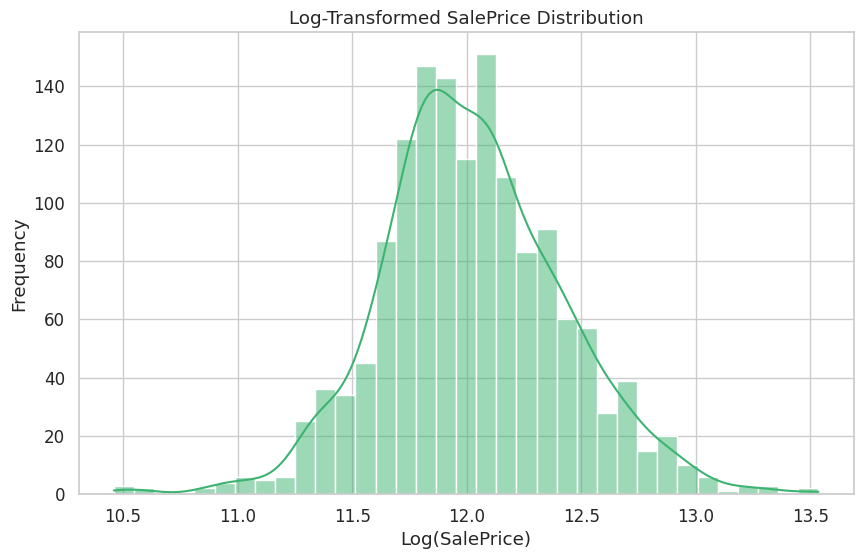

Skewness: 0.12134661989685329
Kurtosis: 0.809519155707878


In [28]:
# Define y (log-transformed target)
y = np.log1p(train_labels)

# Distribution of log-transformed SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, color='mediumseagreen')
plt.title('Log-Transformed SalePrice Distribution')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Skew & kurtosis
print("Skewness:", y.skew())
print("Kurtosis:", y.kurtosis())


Top correlated features:
 OverallQual     0.404427
GrLivArea       0.365639
GarageCars      0.341453
GarageArea      0.335815
KitchenQual     0.327637
ExterQual       0.323500
TotalBsmtSF     0.322190
FullBath        0.310776
YearBuilt       0.308476
1stFlrSF        0.302481
BsmtQual        0.300964
GarageFinish    0.298841
FireplaceQu     0.291209
YearRemodAdd    0.290601
TotRmsAbvGrd    0.286876
Name: SalePrice, dtype: float64


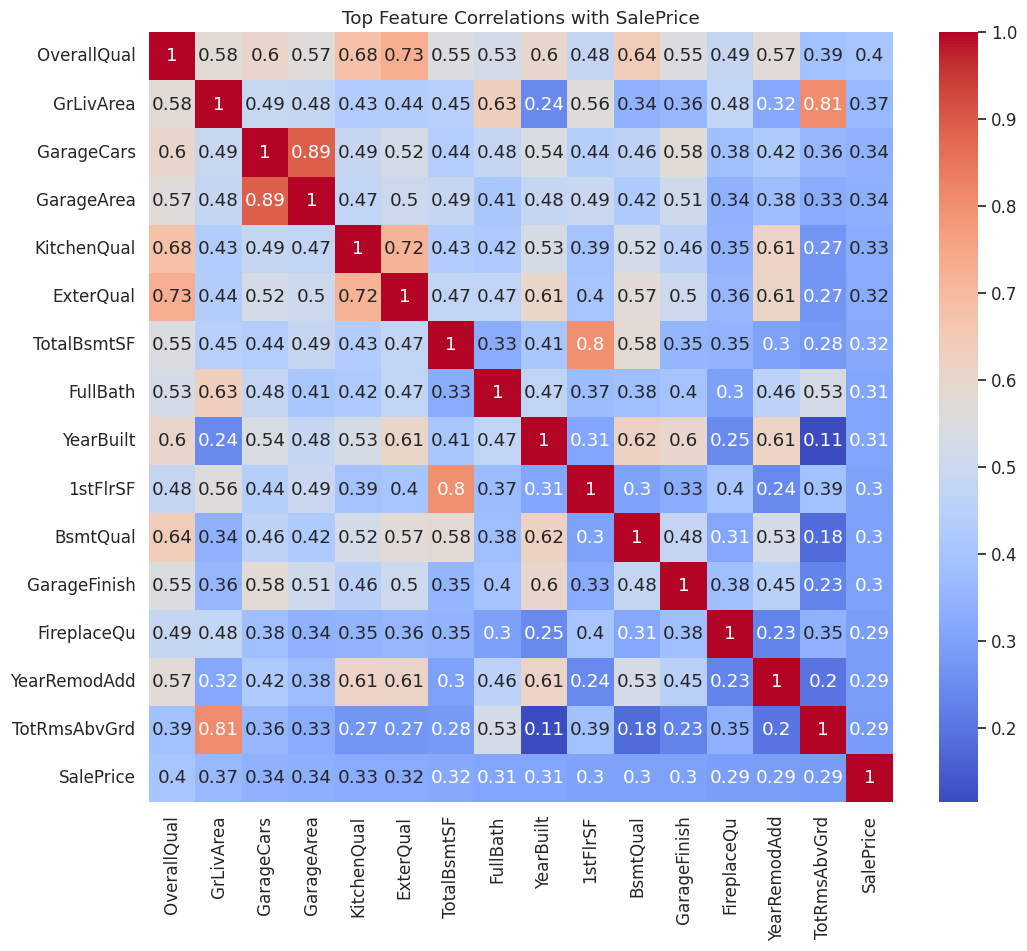

In [29]:
# Recreate eda_df for correlation
eda_df = full.copy()
eda_df['SalePrice'] = y
# Use only numeric columns for correlation
numeric_df = eda_df.select_dtypes(include=[np.number])

# Correlation matrix
corr = numeric_df.corr()

# Top 15 most correlated features with SalePrice
top_corr = corr['SalePrice'].sort_values(ascending=False)[1:16]
print("Top correlated features:\n", top_corr)

# Heatmap of top correlated features
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df[top_corr.index.tolist() + ['SalePrice']].corr(), annot=True, cmap='coolwarm')
plt.title('Top Feature Correlations with SalePrice')
plt.show()

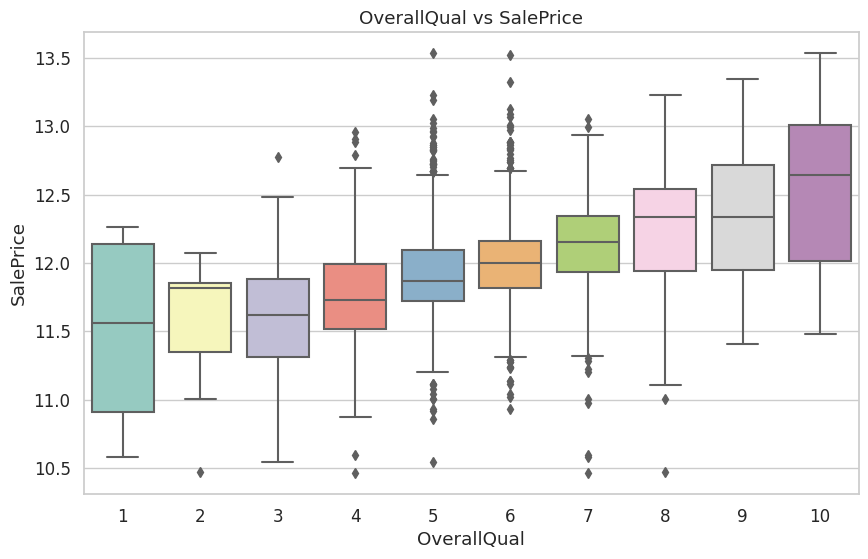

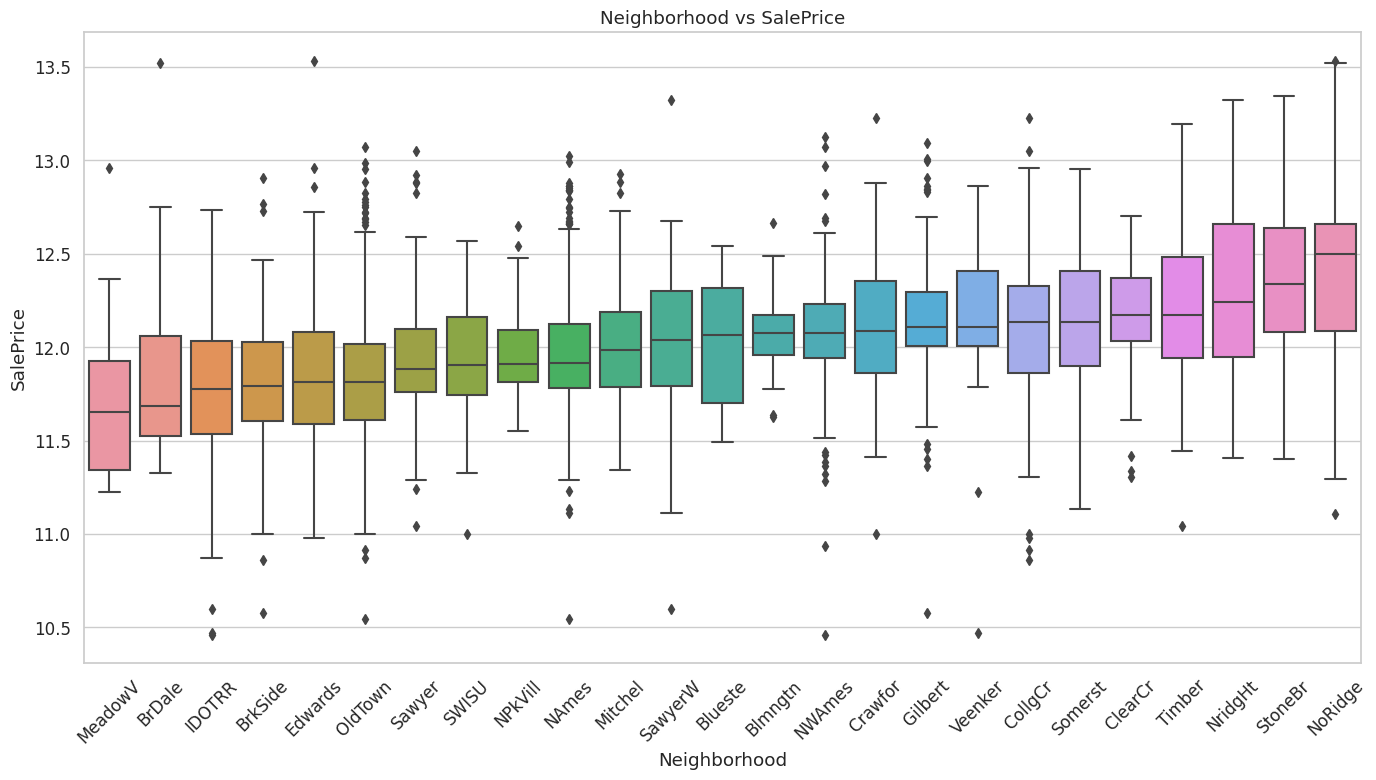

In [30]:
# Boxplot: OverallQual vs SalePrice
plt.figure(figsize=(10, 6))
sns.boxplot(x=eda_df['OverallQual'], y=eda_df['SalePrice'], palette='Set3')
plt.title('OverallQual vs SalePrice')
plt.show()

# Boxplot: Neighborhood vs SalePrice
plt.figure(figsize=(14, 8))
order = eda_df.groupby('Neighborhood')['SalePrice'].median().sort_values().index
sns.boxplot(x='Neighborhood', y='SalePrice', data=eda_df, order=order)
plt.xticks(rotation=45)
plt.title('Neighborhood vs SalePrice')
plt.tight_layout()
plt.show()


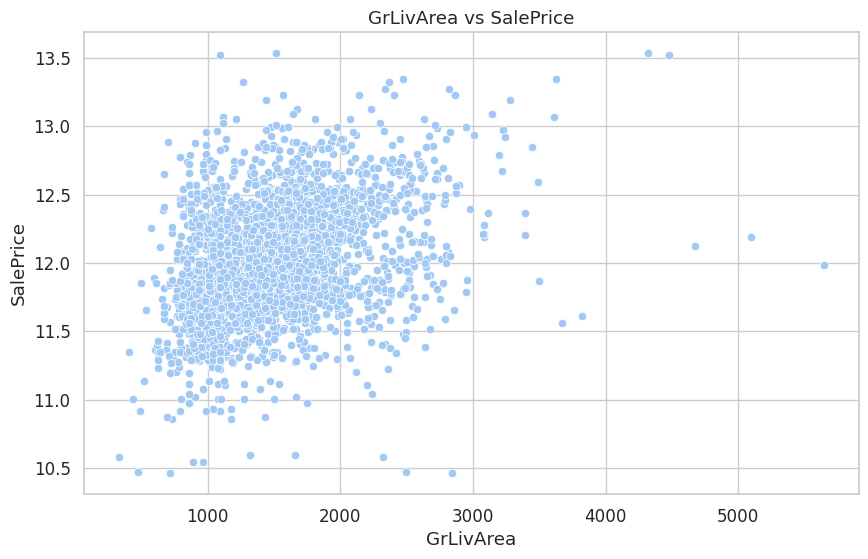

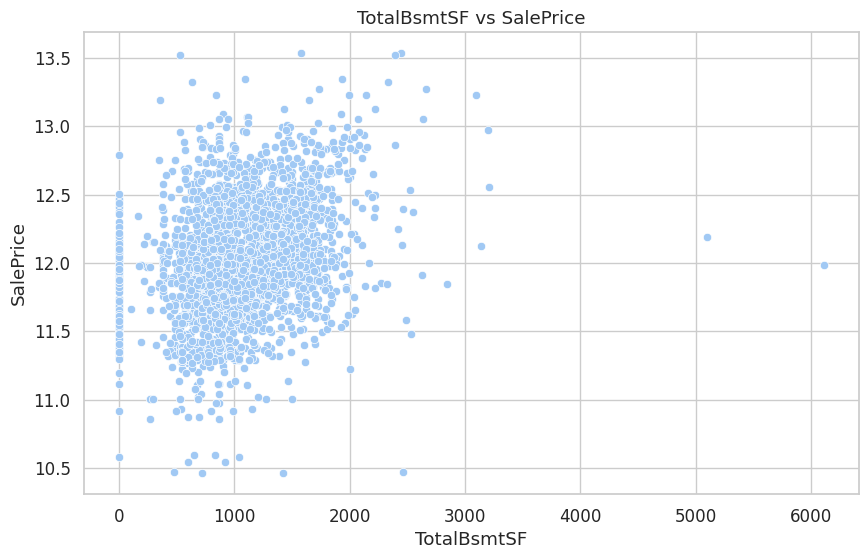

In [31]:
# GrLivArea vs SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(x=eda_df['GrLivArea'], y=eda_df['SalePrice'])
plt.title('GrLivArea vs SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

# TotalBsmtSF vs SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(x=eda_df['TotalBsmtSF'], y=eda_df['SalePrice'])
plt.title('TotalBsmtSF vs SalePrice')
plt.xlabel('TotalBsmtSF')
plt.ylabel('SalePrice')
plt.show()


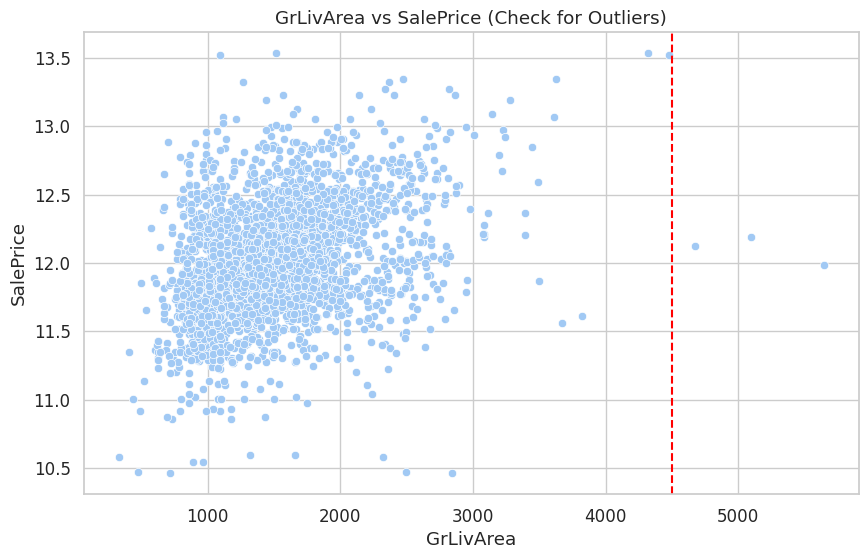

In [32]:
# Outliers in GrLivArea
plt.figure(figsize=(10, 6))
sns.scatterplot(x=eda_df['GrLivArea'], y=eda_df['SalePrice'])
plt.title('GrLivArea vs SalePrice (Check for Outliers)')
plt.axvline(4500, color='red', linestyle='--')
plt.show()

# Suggestion: Drop extreme GrLivArea outliers
eda_df = eda_df[eda_df['GrLivArea'] < 4500]


### Step 6: Feature Engineering

In this step, several new features were created based on domain knowledge and insights from the exploratory data analysis. These engineered features aim to enhance the dataset’s expressiveness and help the model better capture underlying patterns in the data.

#### 6.1 Outlier Removal

Outliers in the `GrLivArea` feature were identified during the EDA phase. Three properties with extremely large above-ground living areas (greater than 4,500 sq ft) but relatively low sale prices were removed from the training set. These outliers could have an undue influence on regression models and were excluded to improve model stability.

#### 6.2 Combined Features

New features were constructed by combining existing related columns:

* **TotalSF**: Represents the total square footage of the house, including basement, first floor, and second floor. This consolidates multiple area features into one comprehensive measure of home size.
* **TotalBath**: Combines all bathrooms, weighting half-baths appropriately. Both basement and above-ground bathrooms are included.
* **TotalPorchSF**: Sums the area of all porch types, capturing the total outdoor amenity space.

These combined features are useful because they express the scale and livability of the house more accurately than individual parts.

#### 6.3 Binary Indicator Features

Several binary features were introduced to indicate the presence or absence of key elements:

* **HasPool**: Indicates whether the property has a pool.
* **Has2ndFloor**: Indicates whether the house has a second story.
* **HasGarage**: Indicates presence of a garage.
* **HasBasement**: Indicates presence of a basement.

These flags can help models learn differences between homes with and without these significant structural components.

#### 6.4 Age-Related Features

Two new features were created to reflect the age of the house and the time since its last remodeling:

* **HouseAge**: Difference between the year sold and the year built.
* **RemodAge**: Difference between the year sold and the last year the property was remodeled.

These features may correlate with the condition and market value of a property and help capture temporal dynamics.

Overall, these engineered features are designed to improve model performance by capturing domain-specific relationships that raw variables alone may not fully represent.


In [33]:
# Remove 3 identified outliers from EDA (GrLivArea > 4500 and low SalePrice)
mask = (full.loc[:len(train_labels)-1, 'GrLivArea'] > 4500) & (np.log1p(train_labels) < 12.5)
outlier_indices = mask[mask].index
full.drop(index=outlier_indices, inplace=True)
train_labels = train_labels.drop(index=outlier_indices).reset_index(drop=True)


In [34]:
# Total square footage of house (above + basement)
full['TotalSF'] = full['TotalBsmtSF'] + full['1stFlrSF'] + full['2ndFlrSF']

# Total bathrooms (full = 1, half = 0.5)
full['TotalBath'] = (full['FullBath'] + 0.5 * full['HalfBath'] +
                     full['BsmtFullBath'] + 0.5 * full['BsmtHalfBath'])

# Total porch area
full['TotalPorchSF'] = (full['OpenPorchSF'] + full['EnclosedPorch'] +
                        full['3SsnPorch'] + full['ScreenPorch'])


In [35]:
# Presence of certain features
full['HasPool'] = (full['PoolArea'] > 0).astype(int)
full['Has2ndFloor'] = (full['2ndFlrSF'] > 0).astype(int)
full['HasGarage'] = (full['GarageArea'] > 0).astype(int)
full['HasBasement'] = (full['TotalBsmtSF'] > 0).astype(int)


In [36]:
full['HouseAge'] = full['YrSold'].astype(int) - full['YearBuilt'].astype(int)
full['RemodAge'] = full['YrSold'].astype(int) - full['YearRemodAdd'].astype(int)


### 7: Final Feature Preparation

This step finalized the dataset's structure and ensured that all features were numerically encoded and appropriately transformed for modeling. It consisted of two main tasks: correcting skew in numeric features and encoding remaining categorical variables.

#### 7.1 Handling Skewed Numeric Features

A review of the numeric features revealed that several variables exhibited significant right-skew. Features with a skewness greater than 0.75 were considered highly skewed and eligible for log transformation to stabilize their distributions. This transformation reduces the impact of outliers and helps improve model performance, particularly for linear models.

Twenty-eight features were identified as skewed, including `MiscVal`, `PoolQC`, `PoolArea`, `HasPool`, `LotArea`, `LowQualFinSF`, `3SsnPorch`, `LandSlope`, `KitchenAbvGr`, and `BsmtFinSF2`. These features were transformed using the log(1 + x) approach, which is numerically stable even in the presence of zeros and small values. This process helped reduce the influence of extreme values and brought the distributions closer to normal.

#### 7.2 One-Hot Encoding of Nominal Categorical Variables

After ordinal features were manually encoded in a previous step, several nominal categorical variables remained. These features had no intrinsic order and were stored as string (object) types. To prepare these for modeling, they were one-hot encoded.

One-hot encoding was applied to all remaining object-type columns in the dataset. Each category within a feature was converted into a separate binary column indicating the presence or absence of that category. To avoid multicollinearity, the first category in each feature was dropped. This ensured a minimal and non-redundant feature representation.

After this transformation, the dataset contained only numeric columns, with the following distribution of data types: 182 boolean columns (resulting from one-hot encoding), 34 float columns, and 25 integer columns. The final dataset shape was 2913 rows by 241 columns.

At this point, the dataset was fully numeric, free of missing values, and ready for modeling. All relevant transformations had been completed to ensure compatibility with a wide range of machine learning algorithms.


In [37]:

from scipy.stats import skew

# Get only numeric features
numeric_feats = full.select_dtypes(include=[np.number])

# Compute skewness
skew_vals = numeric_feats.apply(lambda x: skew(x.dropna()))
skewed = skew_vals[skew_vals > 0.75].sort_values(ascending=False)
print(f"Number of skewed features > 0.75: {len(skewed)}")
skewed.head(10)  # optional preview


Number of skewed features > 0.75: 28


MiscVal         21.924619
PoolQC          19.535366
PoolArea        17.676417
HasPool         15.483996
LotArea         13.118418
LowQualFinSF    12.092710
3SsnPorch       11.364106
LandSlope        4.969445
KitchenAbvGr     4.297140
BsmtFinSF2       4.141222
dtype: float64

In [38]:
# Apply log(1 + x) to reduce skew
for feat in skewed.index:
    full[feat] = np.log1p(full[feat])


In [39]:
# Identify categorical features
categorical_cols = full.select_dtypes(include=['object']).columns
print(f"Number of categorical columns: {len(categorical_cols)}")
print(categorical_cols.tolist())


Number of categorical columns: 28
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


In [40]:
# One-hot encode categorical features
full = pd.get_dummies(full, columns=categorical_cols, drop_first=True)
print(f"Dataset shape after encoding: {full.shape}")


Dataset shape after encoding: (2913, 241)


In [41]:
# Check final data types
full.dtypes.value_counts()


bool       182
float64     34
int64       25
Name: count, dtype: int64

### 9: Model Preparation & Data Splitting

1. Split the cleaned and engineered dataset back into training and test sets.
2. Log-transform the target `SalePrice` (already done — but align it here).
3. Apply standard scaling (needed for models like Lasso, Ridge).
4. Prepare data for training/validation and submission.

In [42]:
# Ensure alignment with dropped outliers
X = full.iloc[:len(train_labels), :].reset_index(drop=True)
X_test = full.iloc[len(train_labels):, :].reset_index(drop=True)
y = np.log1p(train_labels)  # log-transform already applied
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)


## 10. Model Training and Hyperparameter Tuning

#### Regression Modeling and Evaluation

This step involved training, evaluating, and tuning multiple regression models, both linear and non-linear. The goal was to identify the best-performing models using cross-validation and ultimately combine them using a stacked ensemble.

#### 10.1 Models Trained

The following models were trained and evaluated:

* **Linear Models**: Ridge Regression, Lasso Regression (with tuning)
* **Tree-Based Models**: Random Forest, XGBoost, LightGBM
* **Other Models**: Decision Tree, Support Vector Regressor (SVR)
* **Meta-Ensemble**: Stacking Regressor combining the best models

Each model was evaluated using **RMSLE (Root Mean Squared Log Error)** both on the training data and using 5-fold cross-validation.

#### 10.2 Performance Summary

| Model             | Train RMSLE | CV RMSLE (5-Fold) | Tuned           |
| ----------------- | ----------- | ----------------- | --------------- |
| Ridge             | 0.00773     | 0.11468           | ✅ (`α=10`)      |
| Lasso             | 0.00734     | 0.11511           | ✅ (`α=0.0001`)  |
| Random Forest     | 0.00391     | 0.13704           | ❌               |
| XGBoost           | 0.00353     | 0.12211           | ✅               |
| LightGBM          | 0.00052     | 0.12576           | ✅               |
| Decision Tree     | 0.00000     | 0.20016           | ❌ (overfitting) |
| SVR               | 0.01858     | 0.24408           | ❌               |
| **Stacked Model** | 0.00489     | **0.11143**       | ✅               |

#### 10.3 Hyperparameter Tuning

* **Lasso**: Best `α = 0.0001`
* **Ridge**: Best `α = 10`
* **LightGBM**: Best params: `n_estimators=500, learning_rate=0.05, max_depth=3, num_leaves=50`
* **XGBoost**: Tuned with GPU (`tree_method='gpu_hist'`)

#### 10.4 Final Model: Stacked Ensemble

The final model combined the best regressors:


A final Ridge model served as the meta-learner. This ensemble achieved the **lowest cross-validated RMSLE score** of all approaches (`0.11143`), indicating strong generalization and performance stability.


In [43]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_log_error

# Define root mean squared log error
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Ridge Regression with CV
ridge_alphas = [1, 5, 10, 20, 50]
ridge = RidgeCV(alphas=ridge_alphas, cv=5)
ridge.fit(X, y)
ridge_preds = ridge.predict(X)
print("Ridge RMSLE:", rmsle(y, ridge_preds))

# Lasso Regression with CV
lasso_alphas = [1e-4, 1e-3, 1e-2, 1e-1]
lasso = LassoCV(alphas=lasso_alphas, max_iter=10000, cv=5)
lasso.fit(X, y)
lasso_preds = lasso.predict(X)
print("Lasso RMSLE:", rmsle(y, lasso_preds))


Ridge RMSLE: 0.007733741614456806
Lasso RMSLE: 0.007341556014446871


In [44]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)
rf_preds = rf.predict(X)
print("Random Forest RMSLE:", rmsle(y, rf_preds))

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3, random_state=42)
xgb_model.fit(X, y)
xgb_preds = xgb_model.predict(X)
print("XGBoost RMSLE:", rmsle(y, xgb_preds))

# LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=32, random_state=42)
lgb_model.fit(X, y)
lgb_preds = lgb_model.predict(X)
print("LightGBM RMSLE:", rmsle(y, lgb_preds))


Random Forest RMSLE: 0.003917190929158079
XGBoost RMSLE: 0.003532825334395205
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4107
[LightGBM] [Info] Number of data points in the train set: 1458, number of used features: 168
[LightGBM] [Info] Start training from score 12.024015
LightGBM RMSLE: 0.000516455092272608


In [45]:
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
def cv_rmse(model):
    rmse = -cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv=5)
    return rmse.mean()

print("CV RMSLE (Ridge):", cv_rmse(ridge))
print("CV RMSLE (Lasso):", cv_rmse(lasso))
print("CV RMSLE (Random Forest):", cv_rmse(rf))
print("CV RMSLE (XGBoost):", cv_rmse(xgb_model))
print("CV RMSLE (LightGBM):", cv_rmse(lgb_model))


CV RMSLE (Ridge): 0.11467984780420912
CV RMSLE (Lasso): 0.11511486788439909
CV RMSLE (Random Forest): 0.13704265601925103
CV RMSLE (XGBoost): 0.12211136632553621
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3811
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 163
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3823
[LightGBM] 

In [46]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1]}
lasso_grid = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, scoring='neg_root_mean_squared_error')
lasso_grid.fit(X, y)

print("Best Lasso alpha:", lasso_grid.best_params_)
print("Tuned Lasso CV RMSLE:", -lasso_grid.best_score_)


Best Lasso alpha: {'alpha': 0.0001}
Tuned Lasso CV RMSLE: 0.11377140785013609


In [47]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Use the tuned Lasso model (best from GridSearch)
best_lasso = lasso_grid.best_estimator_

# Build the stacking model
stack_model = StackingRegressor(
    estimators=[
        ('ridge', ridge),
        ('lasso', best_lasso),
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('rf', rf)
    ],
    final_estimator=Ridge(alpha=10)
)

# Fit the stacked model
stack_model.fit(X, y)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4107
[LightGBM] [Info] Number of data points in the train set: 1458, number of used features: 168
[LightGBM] [Info] Start training from score 12.024015
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3811
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 163
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found

StackingRegressor(estimators=[('ridge',
                               RidgeCV(alphas=[1, 5, 10, 20, 50], cv=5)),
                              ('lasso', Lasso(alpha=0.0001, max_iter=10000)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=Non...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('lgb',
                               LGBMRegressor(learning_rate=0.05,
                                             n_estimators=1000, num_leaves=32,
                                             random_state=42)),
                              ('rf',
                               RandomForestRegressor(n_estimators=200,
                                                     random_state=42))],
                  final_estimator=Ridge(alpha=10))

In [48]:
# Predict on training set
stack_preds_train = stack_model.predict(X)

# Calculate RMSLE
from sklearn.metrics import mean_squared_log_error
rmsle_score = np.sqrt(mean_squared_log_error(y, stack_preds_train))
print("Stacked Model RMSLE on Train Set:", rmsle_score)


Stacked Model RMSLE on Train Set: 0.004888764561541401


In [49]:
from sklearn.model_selection import cross_val_score
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# Cross-validation RMSLE (5-fold)
stack_cv_score = -cross_val_score(stack_model, X, y, cv=5, scoring="neg_root_mean_squared_error")
print("Stacked Model CV RMSLE scores:", stack_cv_score)
print("Mean CV RMSLE:", stack_cv_score.mean())


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3811
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 163
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3483
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 151
[LightGBM] [Info] Start training from score 12.019483
[LightGBM] [Warning] Found 

In [50]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X, y)

svr = SVR(C=1.0, epsilon=0.2)
svr.fit(X, y)

print("Decision Tree RMSLE:", rmsle(y, dtr.predict(X)))
print("CV RMSLE (Decision Tree):", cv_rmse(dtr))

print("SVR RMSLE:", rmsle(y, svr.predict(X)))
print("CV RMSLE (SVR):", cv_rmse(svr))


Decision Tree RMSLE: 0.0
CV RMSLE (Decision Tree): 0.20015711126128113
SVR RMSLE: 0.018579888752172143
CV RMSLE (SVR): 0.24408134564892414


In [51]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_param_grid = {
    'alpha': [1e-3, 1e-2, 0.1, 1, 10, 50, 100]
}

ridge_grid = GridSearchCV(Ridge(), ridge_param_grid, cv=5, scoring='neg_root_mean_squared_error')
ridge_grid.fit(X, y)

print("Best Ridge alpha:", ridge_grid.best_params_)
print("Best Ridge CV RMSLE:", -ridge_grid.best_score_)


Best Ridge alpha: {'alpha': 10}
Best Ridge CV RMSLE: 0.11447202896501454


In [52]:
import xgboost as xgb

xgb_param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 1.0]
}

xgb_grid = GridSearchCV(
    xgb.XGBRegressor(
        tree_method='gpu_hist',     # ← Enables GPU acceleration
        predictor='gpu_predictor',
        random_state=42,
        verbosity=0
    ),
    xgb_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

xgb_grid.fit(X, y)

print("Best XGB Params:", xgb_grid.best_params_)
print("Best XGB CV RMSLE:", -xgb_grid.best_score_)


Best XGB Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
Best XGB CV RMSLE: 0.11787183883356867


In [53]:
import lightgbm as lgb

lgb_param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'max_depth': [3, 5, -1]
}

lgb_grid = GridSearchCV(
    lgb.LGBMRegressor(
        device='gpu',               # ← Enables GPU usage
        boosting_type='gbdt',
        verbosity=-1 ,
        random_state=42
    ),
    lgb_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

lgb_grid.fit(X, y)

print("Best LGB Params:", lgb_grid.best_params_)
print("Best LGB CV RMSLE:", -lgb_grid.best_score_)


1111 warning warning warning generated generated warning generated.
.
 generated.
.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning gen

Best LGB Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'num_leaves': 31}
Best LGB CV RMSLE: 0.12104265083055861


In [54]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.ensemble import StackingRegressor

# Use tuned versions
best_ridge = ridge_grid.best_estimator_
best_lasso = lasso_grid.best_estimator_
best_xgb   = xgb_grid.best_estimator_
best_lgb   = lgb_grid.best_estimator_

# Build final stacking model with tuned base learners
final_stack_model = StackingRegressor(
    estimators=[
        ('ridge', best_ridge),
        ('lasso', best_lasso),
        ('xgb', best_xgb),
        ('lgb', best_lgb),
        ('rf', rf)
    ],
    final_estimator=Ridge(alpha=10),
    n_jobs=-1
)

# Fit the final stacked model
final_stack_model.fit(X, y)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:55:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.695e+00, tolerance: 2.328e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.163e+00, tolerance: 1.901e-02
  model =

StackingRegressor(estimators=[('ridge', Ridge(alpha=10)),
                              ('lasso', Lasso(alpha=0.0001, max_iter=10000)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_po...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor='gpu_predictor', ...)),
                              ('lgb',
                               LGBMRegressor(device='gpu', learning_rate=0.05,
                                             max_depth=3, n_estimators=500,
                                             random_state=42, verbosity=-1)),
                              ('rf',
                               RandomForestRegressor(n_estimators=200,
                                                     random_state=42))],
                  final_estimator=Ridge(alpha=10), n_jobs=-1)

In [55]:
# RMSLE on training set
stack_train_preds = final_stack_model.predict(X)
stack_train_rmsle = np.sqrt(mean_squared_log_error(y, stack_train_preds))
print("Final Stacked Model Train RMSLE:", stack_train_rmsle)
from sklearn.model_selection import cross_val_score

cv_scores = -cross_val_score(final_stack_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
print("Final Stacked CV RMSLEs:", cv_scores)
print("Mean CV RMSLE:", cv_scores.mean())


Final Stacked Model Train RMSLE: 0.005838173242326986


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:55:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.475e+00, tolerance: 1.460e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:56:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.war

Final Stacked CV RMSLEs: [0.10724436 0.11143294 0.11911682 0.10360669 0.11356299]
Mean CV RMSLE: 0.11099275780970623


In [56]:
import numpy as np

# Predict on test data
final_preds_log = final_stack_model.predict(X_test)

# Convert from log1p back to original scale
final_preds = np.expm1(final_preds_log)


In [58]:
#Use the actual test set length (which is 1459 rows)
X_test = full.iloc[-1459:, :].reset_index(drop=True)
final_preds = np.expm1(final_stack_model.predict(X_test))
submission['SalePrice'] = final_preds
submission.to_csv('submission_stacked_final.csv', index=False)
